<a href="https://colab.research.google.com/github/adryanfitra/CNN-GRU-Network/blob/main/RUL_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O PM_test.txt 
#!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O PM_train.txt  
#!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O PM_truth.txt
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, TimeDistributed

# Load Dataset

In [ ]:
path = "/content/drive/MyDrive/PROJEK_GRU/PROJEKAN_4/"

In [ ]:
OP_SETTING_COLUMNS = ['op_setting_{}'.format(x) for x in range(1, 4)]
SENSOR_COLUMNS = ['sensor_{}'.format(x) for x in range(1, 22)]
CURRENT_DIR = os.path.abspath(os.path.dirname(path))
DATA_DIR = os.path.join(CURRENT_DIR, 'CMAPSSData')

In [ ]:
def read_data(filepath):
    col_names = ['unit', 'time_cycles'] + OP_SETTING_COLUMNS + SENSOR_COLUMNS
    return pd.read_csv(
        filepath,
        sep='\s+',
        header=None,
        names=col_names
    )

def read_dataset(dataset_name):
    TRAIN_FILE = os.path.join(DATA_DIR, f'train_{dataset_name}.txt')
    TEST_FILE = os.path.join(DATA_DIR, f'test_{dataset_name}.txt')
    TEST_RUL_FILE = os.path.join(DATA_DIR, f'RUL_{dataset_name}.txt')

    train_data = read_data(TRAIN_FILE)
    test_data = read_data(TEST_FILE)
    test_rul = np.loadtxt(TEST_RUL_FILE)

    return train_data, test_data, test_rul


def calculate_RUL(X, upper_threshold=None):
    '''
    Calculate Remaining Useful Life per `unit`
    Parameters
    ----------
    X : pd.DataFrame, with `unit` and `time_cycles` columns
    upper_threshold: int, limit maximum RUL valus, default is None
    Returns
    -------
    np.array with Remaining Useful Life values
    '''
    lifetime = X.groupby(['unit'])['time_cycles'].transform(max)
    rul = lifetime - X['time_cycles']

    if upper_threshold:
        rul = np.where(rul > upper_threshold, upper_threshold, rul)

    return rul

In [ ]:
train, test, test_rul = read_dataset('FD001')

print('train:', train.shape)
print('test:', test.shape)
print('test_rul:', test_rul.shape)
train.head(2)

train: (20631, 26)
test: (13096, 26)
test_rul: (100,)


,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


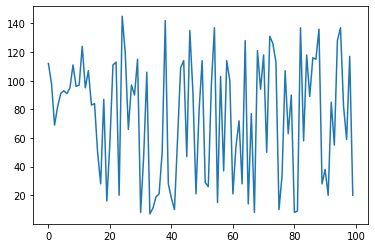

In [ ]:
plt.plot(test_rul)

In [ ]:
X = train[train['unit'] == 10]['time_cycles']
y=calculate_RUL(train[train['unit'] == 10], upper_threshold=135)
y.shape

(222,)

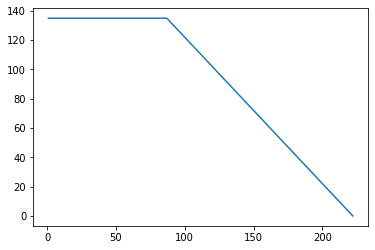

In [ ]:
plt.plot(X, y)

In [ ]:
feature_cols = range(2, 26)
col_dict = {c: 'f{}'.format(c) for c in feature_cols}
feature_cols = [v for _, v in col_dict.items()]

In [ ]:
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split
LAGS = [5, 10, 20, 30, 40]

In [ ]:
def add_total_cycles(data):
    data = data[list(range(0, 26))].rename(columns= {0: 'unit', 1: 'cycle'})
    total_cycles = data.groupby(['unit']).agg({'cycle': 'max'}).reset_index()
    total_cycles = total_cycles.rename(columns={'cycle': 'total_cycles'})
    return data.merge(total_cycles, how='left', left_on='unit', right_on='unit')

def load_train_data(data_name):
    data = pd.read_csv(DATA_DIR+'/train_{}.txt'.format(data_name), sep=' ', header=None)
    data = add_total_cycles(data)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis=1)
    
    return data

def load_test_data(data_name):
    data = pd.read_csv(DATA_DIR+'/test_{}.txt'.format(data_name), sep=' ', header=None)
    data = add_total_cycles(data)
    
    rul = pd.read_csv(DATA_DIR+'/RUL_{}.txt'.format(data_name), sep=' ', header=None)
    rul = rul[list(range(0, 1))]
    rul['unit'] = list(range(1, len(rul) + 1))
    rul = rul.rename(columns = {0: 'RUL'})
    
    data = data.merge(rul, how='left', left_on='unit', right_on='unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis=1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis=1)
    
    return data

In [ ]:
def get_row_lags(unit_data, i, feature_cols):
    periods = LAGS
    ix = [i] + [i - period for period in periods]
    return unit_data.loc[ix, feature_cols].values, unit_data.loc[i, 'RUL']

def get_lagged_unit_data(data, unit, feature_cols):
    periods = LAGS
    unit_data = data[data['unit'] == unit].sort_values(
        by=['cycle'], ascending=True).reset_index(drop=True)

    lagged_unit_data = [get_row_lags(unit_data, i, feature_cols)
                        for i in range(max(periods), len(unit_data))]
    
    return lagged_unit_data

def get_lagged_data(data, feature_cols):
    
    lagged_data = chain(*[get_lagged_unit_data(data, unit, feature_cols)
                          for unit in data['unit'].unique()])
    
    measurement, rul = zip(*list(lagged_data))
    return np.array(measurement), np.array(rul)

In [ ]:
dataset_name = 'FD001'

feature_cols = range(2, 26)
col_dict = {c: 'f{}'.format(c) for c in feature_cols}
feature_cols = [v for _, v in col_dict.items()]

train = load_train_data(dataset_name).rename(columns=col_dict)
test = load_test_data(dataset_name).rename(columns=col_dict)

scaler = StandardScaler()
pca = PCA(n_components=len(feature_cols))

train.loc[:, feature_cols] = scaler.fit_transform(train.loc[:, feature_cols])
train.loc[:, feature_cols] = pca.fit_transform(train.loc[:, feature_cols])

test.loc[:, feature_cols] = scaler.transform(test.loc[:, feature_cols])
test.loc[:, feature_cols] = pca.transform(test.loc[:, feature_cols])

x_train, y_train = get_lagged_data(train, feature_cols)
x_test, y_test = get_lagged_data(test, feature_cols)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [ ]:
x_train.shape, y_train.shape

((12473, 6, 24), (12473,))

In [ ]:
y_train[:10]

array([108,  61,  89,  78, 113,  30,  17,  94,  34, 127])

In [ ]:
x_test.shape

(9115, 6, 24)

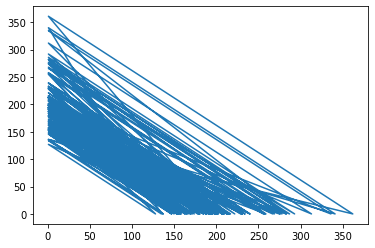

In [ ]:
m = 3
plt.plot(train[train['unit'] == m]['cycle'], train[train['unit'] == m]['RUL'])

In [ ]:
sequence_length = 6
nb_features = 24
nb_out = 1

## CNN_GRU

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(sequence_length, nb_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(TimeDistributed(Flatten()))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(50, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(nb_out, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 6, 64)             4672      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 6, 64)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 32)             6176      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 time_distributed_2 (TimeDis  (None, 6, 32)           

In [ ]:
# fit the network
history = model.fit(x_train, y_train, epochs=30, batch_size=10, validation_data=(x_val, y_val), verbose=1)

Epoch 1/30
1248/1248 [==============================] - 17s 9ms/step - loss: 6598.1836 - mae: 62.6464 - val_loss: 4467.9932 - val_mae: 51.6718
Epoch 2/30
1248/1248 [==============================] - 11s 9ms/step - loss: 3854.0034 - mae: 48.7872 - val_loss: 3600.5164 - val_mae: 48.4441
Epoch 3/30
1248/1248 [==============================] - 11s 9ms/step - loss: 3546.0361 - mae: 47.9991 - val_loss: 3558.9131 - val_mae: 48.5878
Epoch 4/30
1248/1248 [==============================] - 11s 9ms/step - loss: 2568.5098 - mae: 36.9662 - val_loss: 1560.2799 - val_mae: 25.9797
Epoch 5/30
1248/1248 [==============================] - 11s 9ms/step - loss: 1364.7434 - mae: 24.7219 - val_loss: 1155.7449 - val_mae: 22.5309
Epoch 6/30
1248/1248 [==============================] - 11s 9ms/step - loss: 1154.3788 - mae: 22.9013 - val_loss: 1051.0190 - val_mae: 21.8572
Epoch 7/30
1248/1248 [==============================] - 12s 9ms/step - loss: 1076.1252 - mae: 22.2206 - val_loss: 1016.8456 - val_mae: 21.5023

In [ ]:
# training metrics
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=10)
print('Accurracy: {}'.format(scores[1]))

#GRU Accurracy: 0.9945620894432068


912/912 [==============================] - 2s 2ms/step - loss: 2084.1497 - mae: 33.0175
Accurracy: 33.01754379272461


In [ ]:
y_pred = model.predict(x_test)

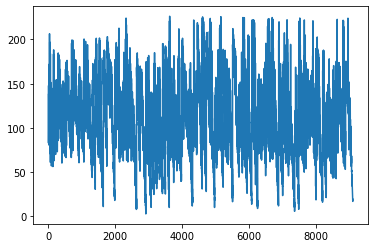

In [ ]:
plt.plot(y_pred)

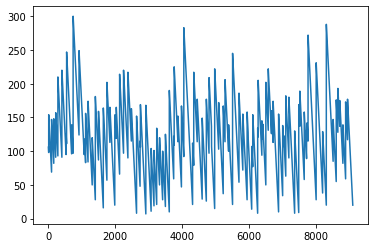

In [ ]:
plt.plot(y_test)

In [ ]:
len(test['RUL'])

13096

In [ ]:
len(y_test)

9115

## Model Evaluation on Test set

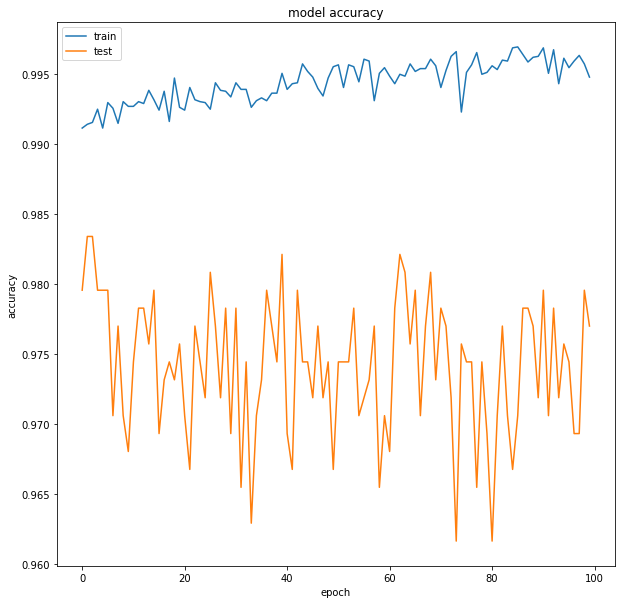

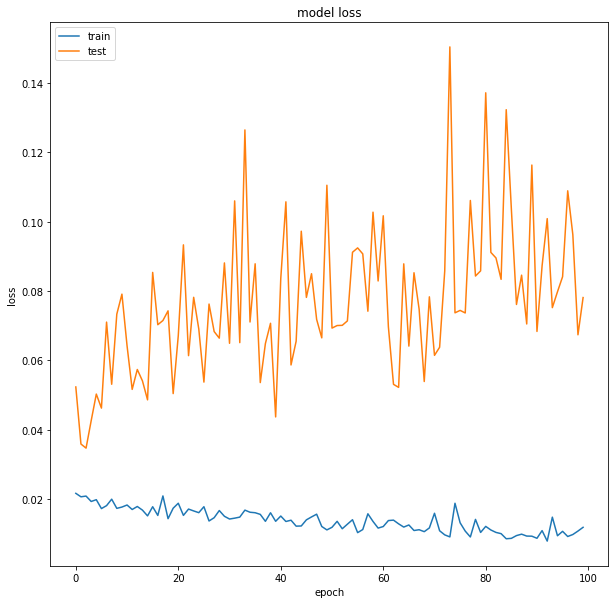

157/157 [==============================] - 2s 11ms/step - loss: 0.0081 - accuracy: 0.9980
Accurracy: 0.9980167746543884
157/157 [==============================] - 2s 8ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12513    18]
 [   13  3087]]
precision =  0.9942028985507246 
 recall =  0.9958064516129033


In [ ]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=100)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=100)
y_pred = np.round(y_pred).astype(int)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

In [ ]:
# We pick the last sequence for each id in the test data
"""
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict(seq_array_test_last)
y_pred_test = np.round(y_pred_test).astype(int)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

"""

'\nseq_array_test_last = [test_df[test_df[\'id\']==id][sequence_cols].values[-sequence_length:] \n                       for id in test_df[\'id\'].unique() if len(test_df[test_df[\'id\']==id]) >= sequence_length]\n\nseq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)\n#print("seq_array_test_last")\n#print(seq_array_test_last)\n#print(seq_array_test_last.shape)\n\n# Similarly, we pick the labels\n\n#print("y_mask")\n# serve per prendere solo le label delle sequenze che sono almeno lunghe 50\ny_mask = [len(test_df[test_df[\'id\']==id]) >= sequence_length for id in test_df[\'id\'].unique()]\n#print("y_mask")\n#print(y_mask)\nlabel_array_test_last = test_df.groupby(\'id\')[\'label1\'].nth(-1)[y_mask].values\nlabel_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)\n#print(label_array_test_last.shape)\n#print("label_array_test_last")\n#print(label_array_test_last)\n\n# if best iteration\'s model was saved then load and u

# Regression
How many more cycles an in-service engine will last before it fails?

In [ ]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

## Data Ingestion

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## Data Preprocessing

In [ ]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]
142
(15631, 50, 25)


(15631, 1)

## LSTM

In [ ]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
__________________________________________________

## Model Evaluation on Test set

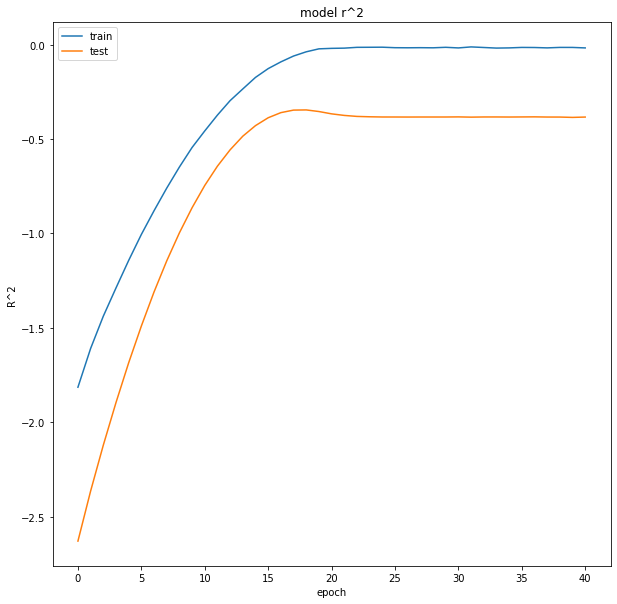

KeyError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

## Evaluate on Validation set

3/3 - 1s - loss: 1821.9526 - mae: 35.9903 - r2_keras: -9.7608e-02

MAE: 35.990291595458984

R^2: -0.09760820865631104


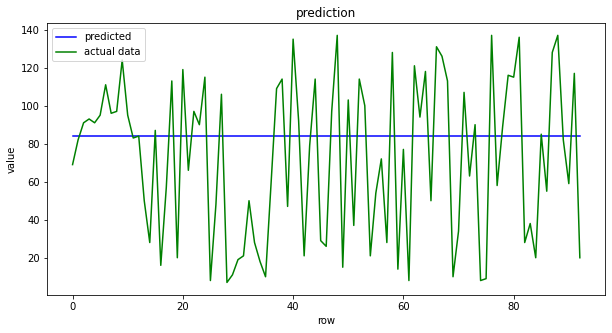

In [ ]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

# References


- [1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- [3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA 
- [4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

